170498071/170498071 [==============================] - 3s 0us/step


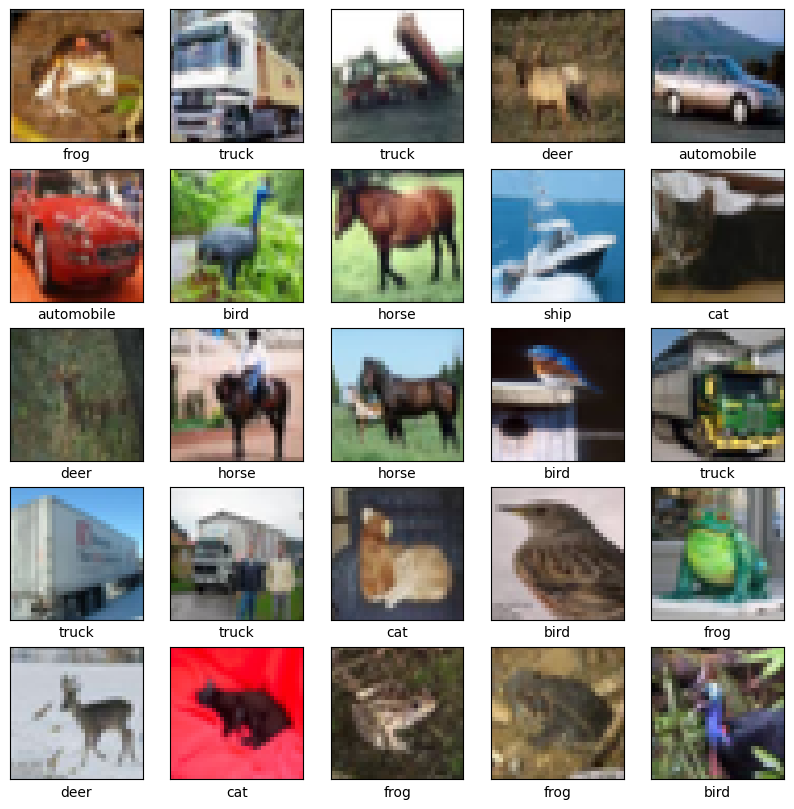

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

KeyboardInterrupt: ignored

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


# loading the data
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()


# normalization to [0;1] range
train_images, test_images = train_images / 255.0, test_images / 255.0

#names of classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',  'dog', 'frog', 'horse', 'ship', 'truck']

#showing example figures
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels))


plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

# https://www.tensorflow.org/tutorials/images/cnn?hl=pl

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

!mkdir /content/gdrive/My\ Drive/Colab_Models

Mounted at /content/gdrive


In [ ]:
model.save('/content/gdrive/My Drive/Colab_Models/model_1.h5')

In [2]:
!pip install --user --upgrade tensorflow-model-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 80.4 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import tensorflow_model_optimization as tfmot
import tempfile

# loading the data
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()


# normalization to [0;1] range
train_images, test_images = train_images / 255.0, test_images / 255.0

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
VALIDATION_SPLIT = 0.1 # 10% of training set will be used for validation set.
EPOCHS=6
BATCH_SIZE=64

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
images, labels = next(iter(train_ds))

num_images = train_images.shape[0] * (1 - VALIDATION_SPLIT)
end_step = np.ceil(num_images / BATCH_SIZE).astype(np.int32) * EPOCHS



# Define model for pruning
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.40,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}
if False:

  from google.colab import drive 
  drive.mount('/content/gdrive')

  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(10))

  model.load_weights("/content/gdrive/My Drive/Colab_Models/model_1.h5")

else:
  model = keras.models.load_model

model_for_pruning = prune_low_magnitude(model, **pruning_params)

model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model_for_pruning.summary()


logdir = tempfile.mkdtemp()
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]
history = model_for_pruning.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=EPOCHS, callbacks=callbacks)


_, model_for_pruning_accuracy = model_for_pruning.evaluate(test_images,  test_labels, verbose=2)
print("Pruned test accuracy: {:.2f}%".format(model_for_pruning_accuracy * 100))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d_  (None, 30, 30, 32)       1762      
 9 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 15, 15, 32)       1         
 ling2d_6 (PruneLowMagnitude                                     
 )                                                               
                                                                 
 prune_low_magnitude_conv2d_  (None, 13, 13, 64)       36930     
 10 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_max_poo  (None, 6, 6, 64)         

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)